In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda, Inc.| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.13.1
Pandas Version: 0.20.3


In [267]:
import numpy as np
import pandas as pd

class kde_approximator_1D:
    
    def __init__(self,kernel='gaus', bandwidth=1.):
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.estim = self.gaus
        self.data_cols = None
        
    def gaus(self, x, mu=0, sig=1):
        """
        Returns the probability of x given the mean and standard
        deviation provided - assuming a Gaussian probability.
        ---
        Inputs: x (the value to find the probability for, float),
        mu (the mean value of the feature in the training data, float),
        sig (the standard deviation of the feature in the training data, float)
        Outputs: probability (float)
        """
        norm = 1/(np.sqrt(2*np.pi*sig**2))
        return norm*np.exp(-(x-mu)**2/(2*sig**2))
    
    def fit(self, X):
        """
        ---
        In: X (features), np.array or pandas dataframe/series
        """
        X = self.pandas_to_numpy(X)
        
        if not self.data_cols:
            try: 
                self.data_cols = X.shape[1]
            except IndexError:
                self.data_cols = 1
                
        X = self.check_feature_shape(X)
        
        probs = []
        for col in range(self.data_cols): 
            data = X.T[col]
            rangemin = np.min(data)-abs(np.min(data)*0.10)
            rangemax = np.max(data)+abs(np.max(data)*0.10)
            span = np.linspace(rangemin, rangemax, 200)
            for p in span:
                prob = 0.
                for d in data:
                    prob += self.estim(p,mu=d,sig=self.bandwidth)
                probs.append(prob)
        self.region = span 
        self.probs = probs
    
    def check_feature_shape(self, x):
        """
        Helper function to make sure any new data conforms to the fit data shape
        ---
        In: numpy array, (unknown shape)
        Out: numpy array, shape: (rows, self.data_cols)"""
        return x.reshape(-1,self.data_cols)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return np.array(x)
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x)
        
    

In [268]:
X = np.hstack((np.random.normal(0,0.5,100), np.random.normal(5,1,100), np.random.normal(-5,2,50)))
X.shape

(250,)

In [269]:
kde = kde_approximator_1D(bandwidth=1)
kde.fit(X)

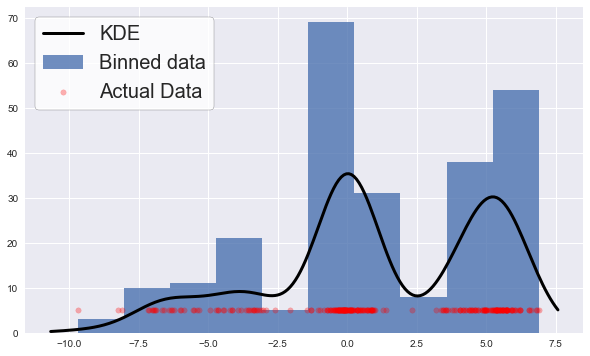

In [270]:
plt.figure(figsize=(10,6))

plt.hist(X, label="Binned data", alpha=0.8, zorder=1)
plt.plot(kde.region, kde.probs, c='k', lw=3, label="KDE", zorder=2);
plt.scatter(X, [5]*len(X), marker='o', c='r', s=30, alpha=0.3,label='Actual Data', zorder=3)
plt.legend(fontsize=20, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');

In [271]:
import numpy as np
import pandas as pd

class kde_approximator:
    
    def __init__(self,kernel='gaus', bandwidth=1., grid_fineness=10):
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.estim = self.gaus
        self.data_cols = None
        self.grid_fineness = grid_fineness
        
    def gaus(self, x, mu=0, sig=1):
        """
        Returns the probability of x given the mean and standard
        deviation provided - assuming a Gaussian probability.
        ---
        Inputs: x (the value to find the probability for, float),
        mu (the mean value of the feature in the training data, float),
        sig (the standard deviation of the feature in the training data, float)
        Outputs: probability (float)
        """
        diff = np.sqrt(np.sum((x-mu)**2))
        norm = 1/(np.sqrt(2*np.pi*sig**2))
        return norm*np.exp(-diff**2/(2*sig**2))
    
    def get_grid(self, X):
        if not self.data_cols:
            try: 
                self.data_cols = X.shape[1]
            except IndexError:
                self.data_cols = 1
        mins, maxes = [], []
        
        for col in range(self.data_cols): 
            data = X.T[col]
            mins.append(np.min(data)-abs(np.min(data)*0.10))
            maxes.append(np.max(data)+abs(np.max(data)*0.10))
        grid = np.stack(np.meshgrid(*[np.linspace(i,j,self.grid_fineness) for i,j in zip(mins, maxes)], indexing='ij'),self.data_cols)
        return grid
    
    def fit(self, X):
        """
        ---
        In: X (features), np.array or pandas dataframe/series
        """
        X = self.pandas_to_numpy(X)
        
        if not self.data_cols:
            try: 
                self.data_cols = X.shape[1]
            except IndexError:
                self.data_cols = 1
                
        X = self.check_feature_shape(X) 
        span = self.get_grid(X)
        
        probs = []
        points = []
        for dim in span:
            for p in dim:
                prob = 0.
                for d in X: 
                    prob += self.estim(p,mu=d,sig=self.bandwidth)
                points.append(p)
                probs.append(prob)
        self.region = points 
        self.probs = probs
    
    def check_feature_shape(self, x):
        """
        Helper function to make sure any new data conforms to the fit data shape
        ---
        In: numpy array, (unknown shape)
        Out: numpy array, shape: (rows, self.data_cols)"""
        return x.reshape(-1,self.data_cols)
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return np.array(x)
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x)
        
    

In [323]:
X = np.vstack((np.random.normal(0,0.5,(100,2)), np.random.normal(5,1,(100,2)), np.random.normal(-5,1.5,(300,2))))
X.shape

(500, 2)

In [324]:
kde2 = kde_approximator(grid_fineness=100, bandwidth=1)
kde2.fit(X)

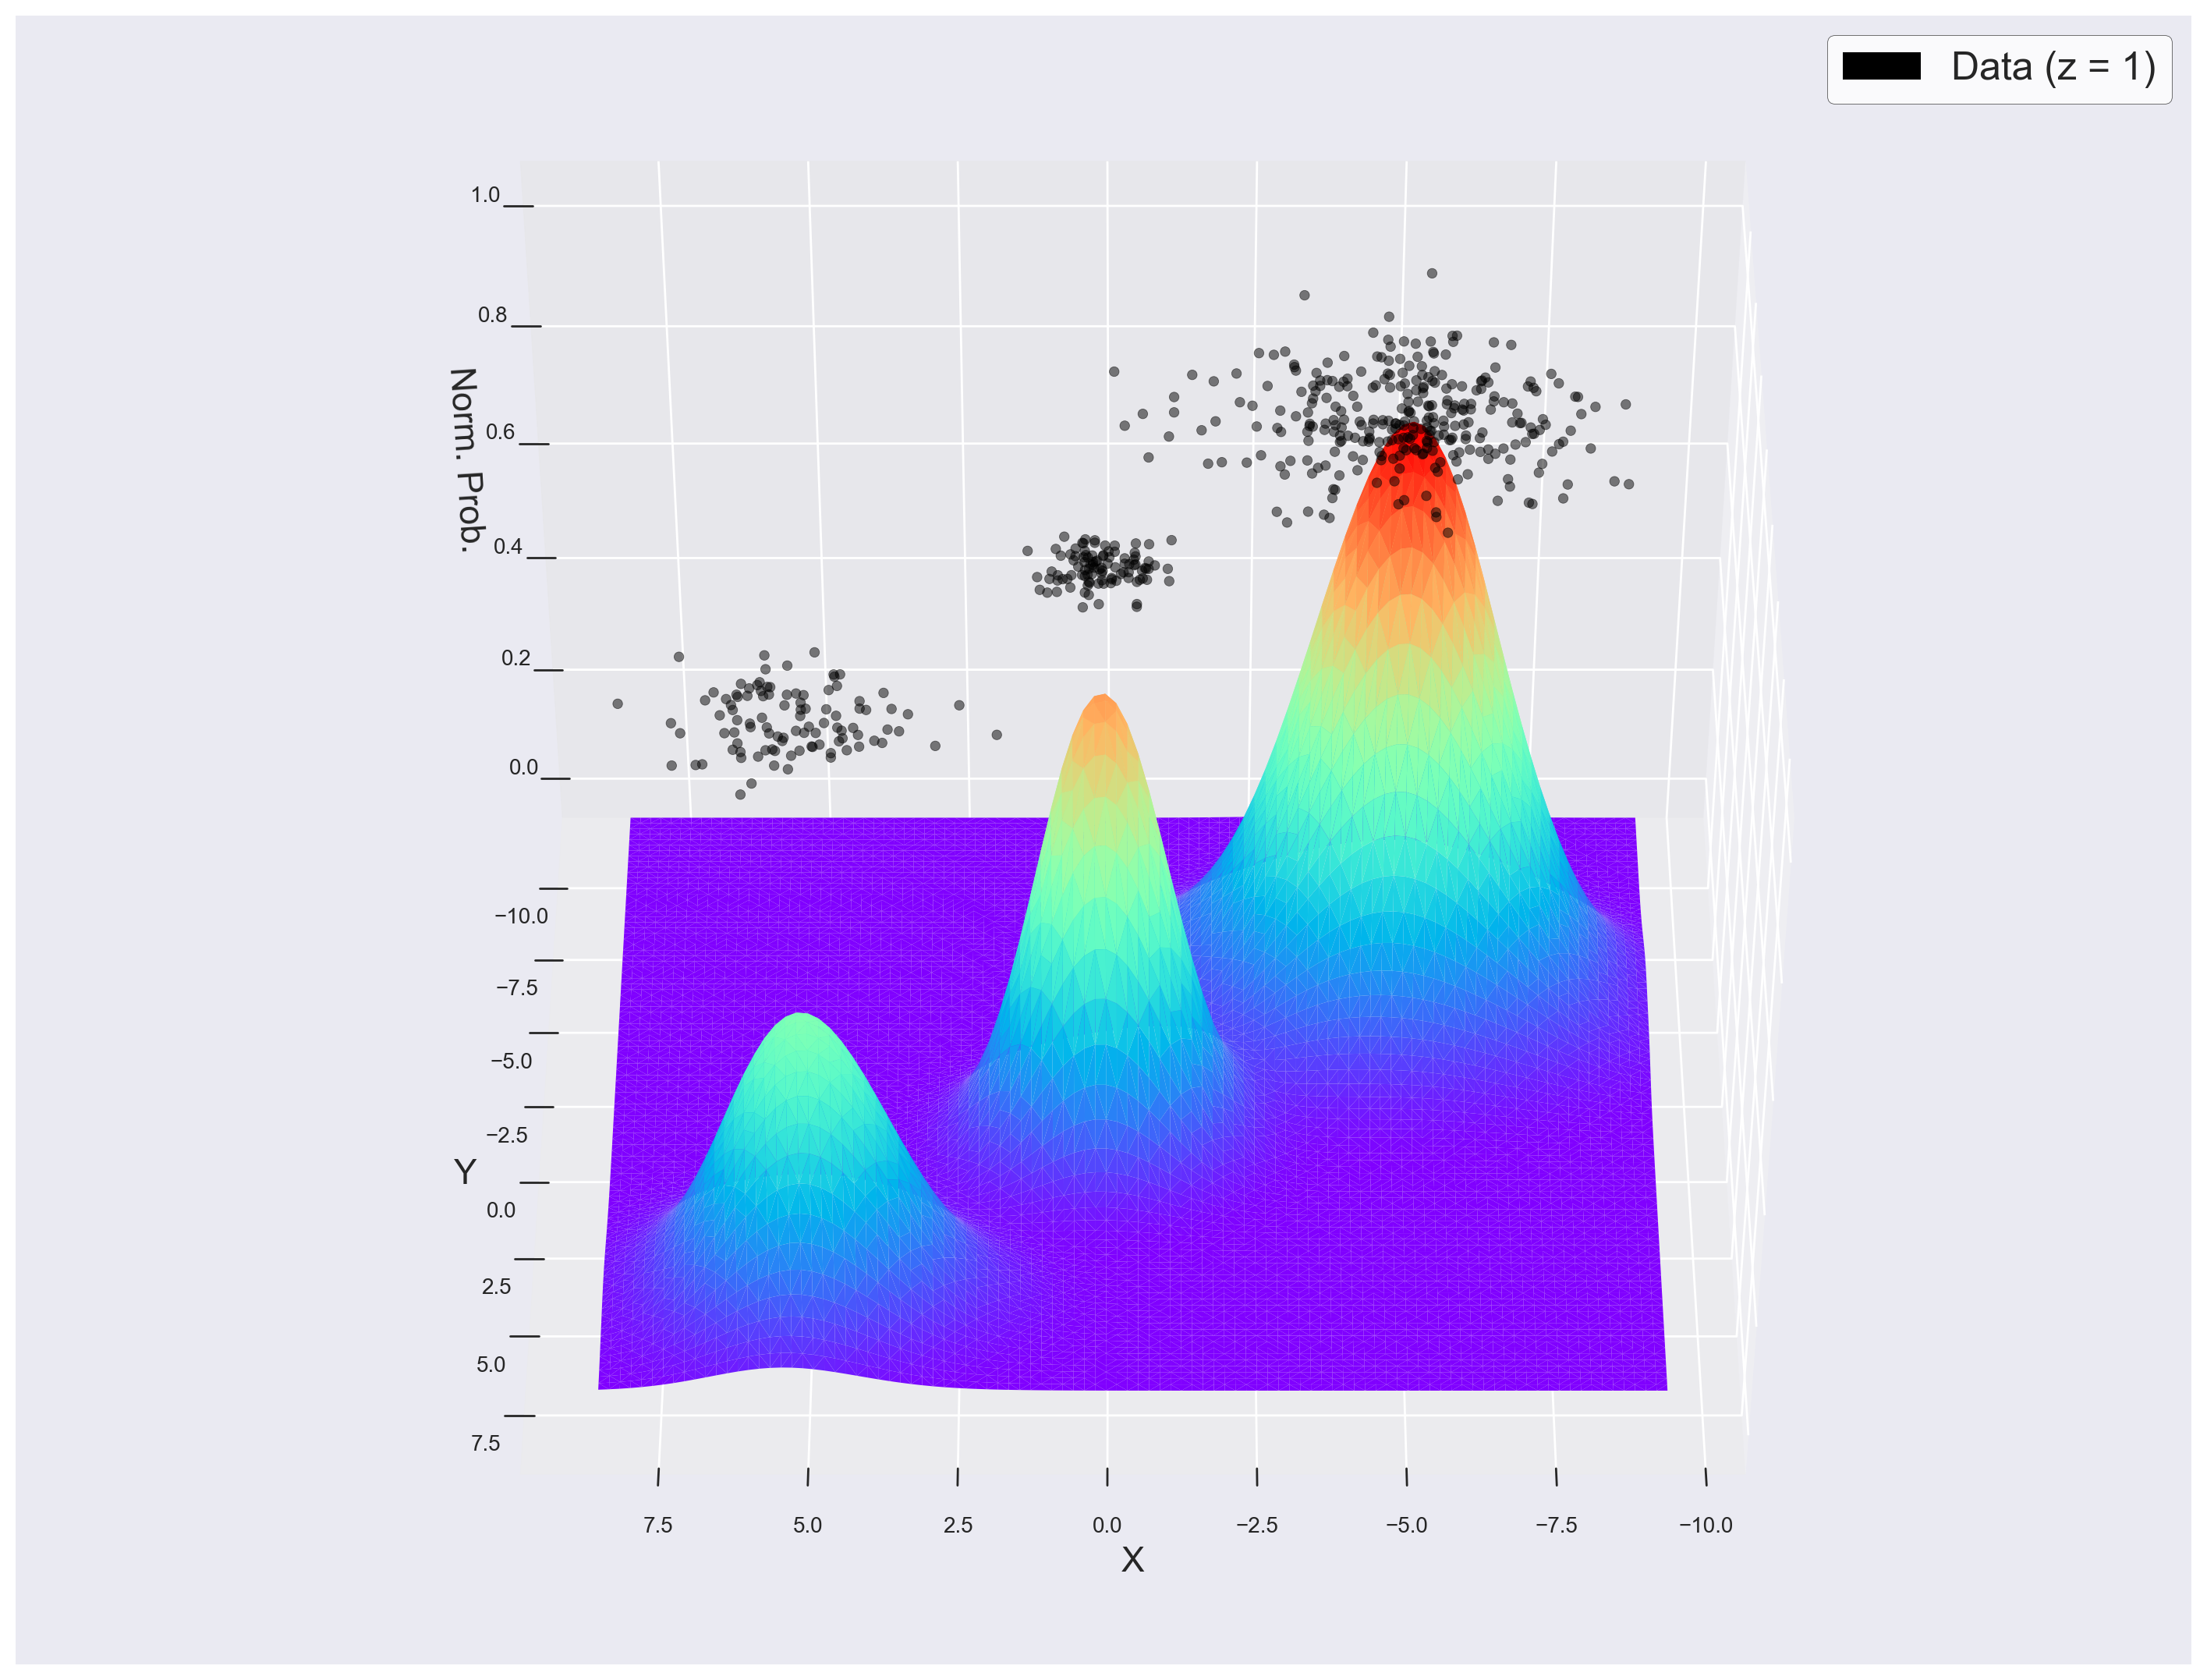

In [332]:
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')
def make_plot():
    Xpl, Ypl  = zip(*kde2.region)
    Zpl = kde2.probs/max(kde2.probs)
    fig = plt.figure(dpi=200, figsize=(18,14))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(Xpl,Ypl,Zpl, cmap=plt.cm.rainbow, linewidth=1)

    Xsc, Ysc = zip(*X)
    ax.scatter(Xsc,Ysc,[max(Zpl)]*len(Xsc),c='k',s=20, label="Data", alpha=0.5);
    proxy = plt.Circle((0,0), fc="k")
    ax.legend([proxy],['Data (z = 1)'], fontsize=18, loc='upper right', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');
    ax.set_zlabel("Norm. Prob.",fontsize=16, labelpad=10)
    ax.set_xlabel("X",fontsize=16, labelpad=10)
    ax.set_ylabel("Y",fontsize=16, labelpad=10);
    return ax

ax = make_plot()
ax.view_init(45,90);

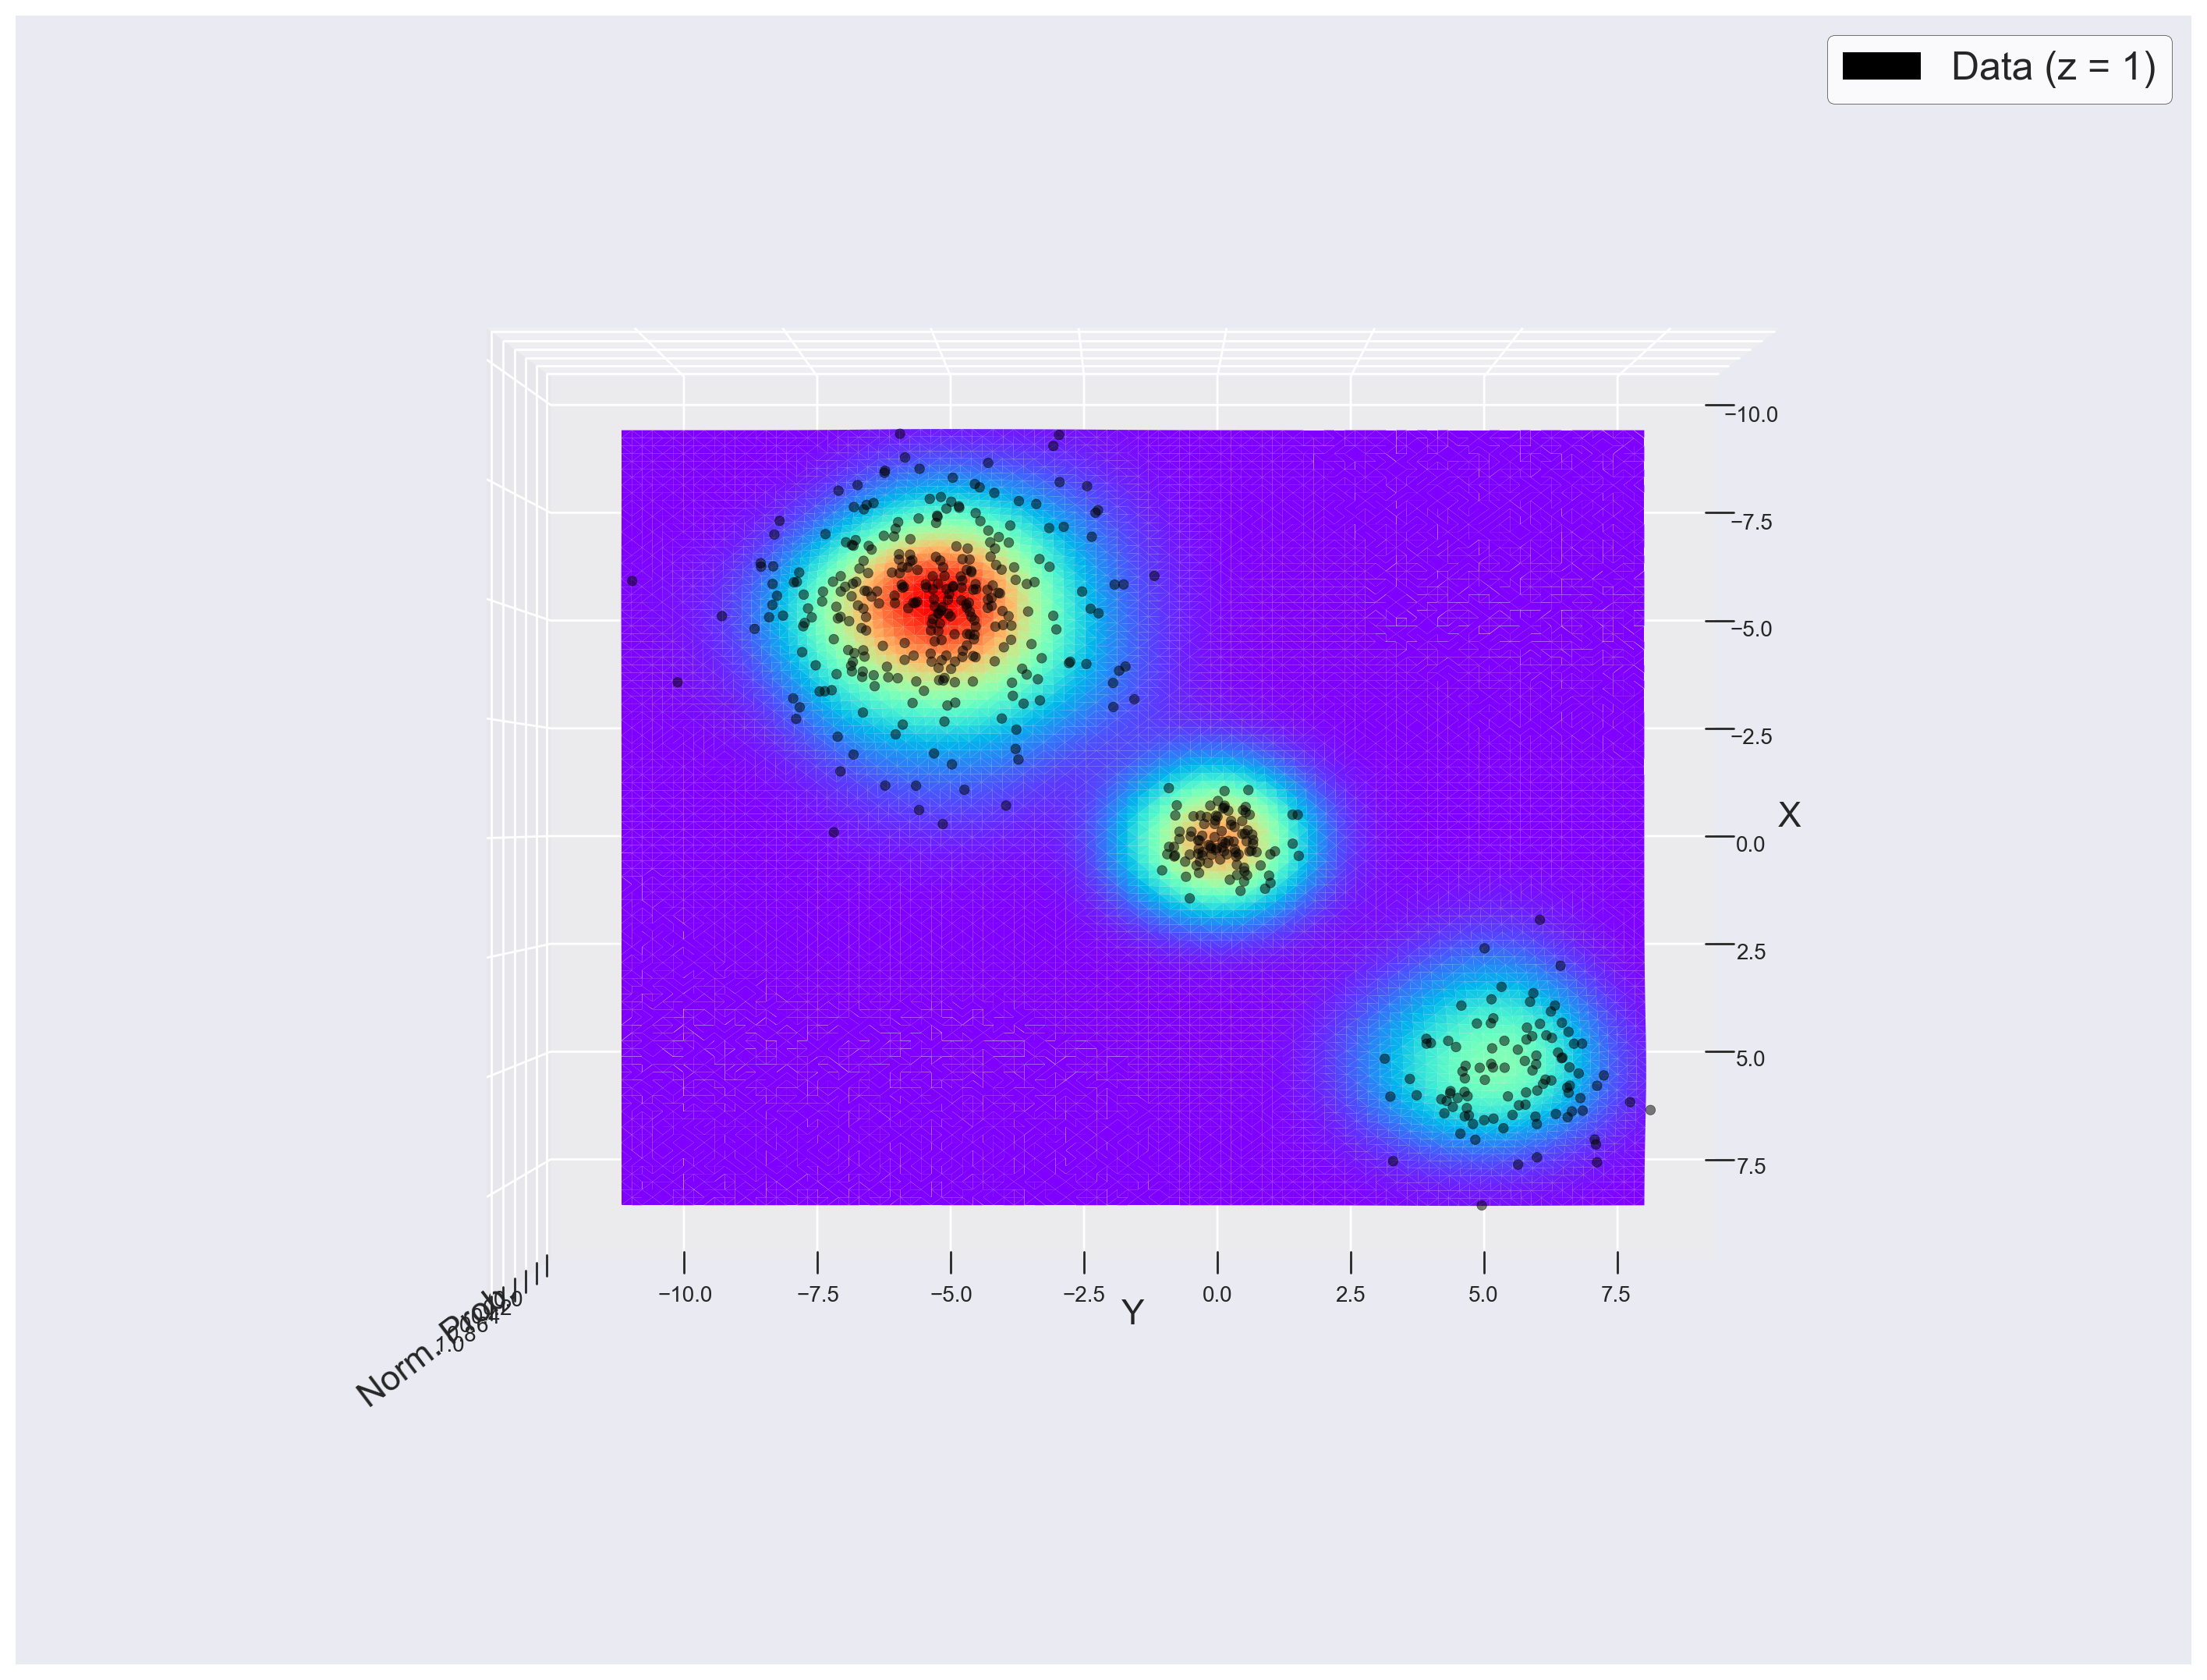

In [333]:
ax = make_plot()
ax.view_init(90,0);

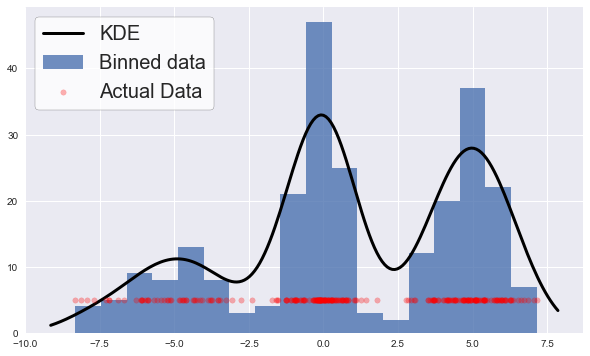

In [339]:
X = np.hstack((np.random.normal(0,0.75,100), np.random.normal(5,1,100), np.random.normal(-5,1.5,50)))
X.shape

kde = kde_approximator(grid_fineness=200)
kde.fit(X)

plt.figure(figsize=(10,6))

plt.hist(X, label="Binned data", bins=18, alpha=0.8, zorder=1)
plt.plot(kde.region, kde.probs, c='k', lw=3, label="KDE", zorder=2);
plt.scatter(X, [5]*len(X), marker='o', c='r', s=30, alpha=0.3,label='Actual Data', zorder=3)
plt.legend(fontsize=20, loc='upper left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333');